In [81]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from matplotlib import gridspec

%matplotlib inline

# Define linear program as a function of $P(Y)$, $\lambda$, and $\epsilon$

In [152]:
K = 6
def get_lp(py,lamb,eps,err_const=True,mon_const=True,sym_const=True):
    c = np.zeros((K,K))
    # obj = \sum_{x\in\{3,4\}} \sum_y \phi_{xy}
#     c[[3,4],:] = 1
    for x in range(K):
        for y in range(K):
            c[x,y] = x
#     print(c)
    c = c.flatten()
    
    # Equality constraints
    A_eq = []
    b_eq = []
    
    # Inequality (upper bound) constraints
    A_ub = []
    b_ub = []
    
    # observed data constraint
    # \sum_{x} \phi_{xy} = P(Y=y)
    for y in range(K):
        a = np.zeros((K,K))
        a[:,y] = 1
        A_eq.append(a.flatten())
        b_eq.append(py[y])
        
    
    # bound on proportion of errors
    # \sum_{x,y: |x-y| > 2} \phi_{xy} <= \epsilon
    if err_const:
        a = np.zeros((K,K))
        for x in range(K):
            for y in range(K):
                if np.abs(x-y) > 2:
                    a[x,y] = 1
        A_ub.append(a.flatten())
        b_ub.append(eps)
    
    # monotonicity constraint
    # \phi_{xy} - \phi_{xy'} <= 0 for all |x - y| > |x - y'|
    if mon_const:
        for x in range(K):
            for y in range(K):
                for yp in range(K):
                    if np.abs(x-y) < np.abs(x-yp):
                        a = np.zeros((K,K))
                        a[x,y]  = -1
                        a[x,yp] = 1
                        A_ub.append(a.flatten())
                        b_ub.append(0)
                    
    # approximate symmetry constraint
    # |\phi_{xy} - \phi_{xy'}| <= \lambda for all |x - y| = |x - y'|
    if sym_const:
        for x in range(K):
            for y in range(K):
                for yp in range(K):
                    if np.abs(x-y) == np.abs(x-yp) and y != yp:
                        a = np.zeros((K,K))
                        a[x,y]  = 1
                        a[x,yp] = -1
                        A_ub.append(a.flatten())
                        b_ub.append(lamb)

                        a = np.zeros((K,K))
                        a[x,y]  = -1
                        a[x,yp] = 1
                        A_ub.append(a.flatten())
                        b_ub.append(lamb)
                    
    # non-negativity
    bounds = []
    for x in range(K):
        for y in range(K):
            bounds.append((0,1))

    A_eq = np.array(A_eq)
    b_eq = np.array(b_eq)
    
    if len(A_ub) == 0:
        A_ub = None
        b_ub = None
    else:
        A_ub = np.array(A_ub)
        b_ub = np.array(b_ub)
    
    return c,A_eq,b_eq,A_ub,b_ub,bounds
    
def get_bounds(py,lamb,eps,err_const=True,mon_const=True,sym_const=True):
    # Get LP params
    c,A_eq,b_eq,A_ub,b_ub,bounds = get_lp(py,lamb,eps,err_const,mon_const,sym_const)
    
    # Solve for lower bound
    lb_res = linprog(c,A_eq=A_eq,b_eq=b_eq,A_ub=A_ub,b_ub=b_ub,bounds=bounds)
    
    # Solve for upper bound
    ub_res = linprog(-c,A_eq=A_eq,b_eq=b_eq,A_ub=A_ub,b_ub=b_ub,bounds=bounds)
    
    return lb_res.fun,-ub_res.fun

## Solve for bounds with exponential(ish) and normal(ish) observed proxy distributions

P(Y) = [0.51 0.25 0.13 0.06 0.03 0.02]


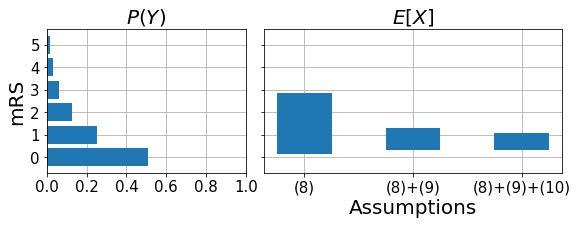

P(Y) = [0.05 0.1  0.19 0.38 0.19 0.1 ]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:98: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:98: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
/anaconda3/lib/python3.6/site-packages/scipy/optimize/_linprog_ip.py:110: LinAlgWarning: Ill-conditioned matrix (rcond=2.36951e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


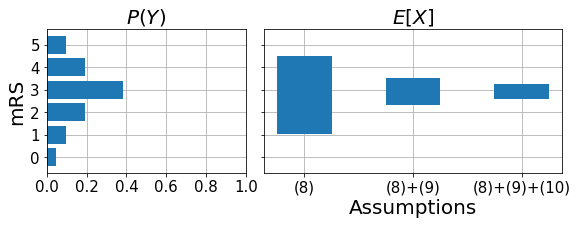

In [163]:
pys = []
py = np.array([32.,16.,8.,4.,2.,1.])
py /= np.sum(py)
pys.append(py)
py = np.array([4.,8.,16.,32.,16.,8.])
py /= np.sum(py)
pys.append(py)

fnames = ["mrs_exp.pdf","mrs_norm.pdf"]

for i,py in enumerate(pys):
    print(f"P(Y) = {py}")
    
    bounds = []
    bounds.append(get_bounds(py,0.01,0.01,err_const=True,mon_const=False,sym_const=False))
    bounds.append(get_bounds(py,0.01,0.01,err_const=True,mon_const=True,sym_const=False))
    bounds.append(get_bounds(py,0.01,0.01,err_const=True,mon_const=True,sym_const=True))

    
    
    fig = plt.figure(figsize=(8,3))

    spec = gridspec.GridSpec(ncols=2, nrows=1,
                             width_ratios=[1, 1.5])

    ax0 = fig.add_subplot(spec[0])
    plt.barh(range(K),py)
    ylim = plt.gca().get_ylim()
#     plt.ylim([0,5])
#     plt.xticks(range(K),fontsize=15)
    plt.xticks(np.arange(0,1.1,0.2),fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel("mRS",fontsize=20)
    plt.grid()
    plt.title(r"$P(Y)$",fontsize=20)
    ax0.set_axisbelow(True)

    ax1 = fig.add_subplot(spec[1])
    plt.bar(range(3),[b[1]-b[0] for b in bounds],bottom=[b[0] for b in bounds],width=0.5)
#     plt.ylim([0,5])
    plt.ylim(ylim)
    plt.grid()
    ax1.set_axisbelow(True)
    plt.xticks([0,1,2],["(8)","(8)+(9)","(8)+(9)+(10)"],fontsize=15)
#     plt.yticks(np.arange(0,1.1,0.2),["" for y in np.arange(0,1.1,0.2)])
    plt.yticks(np.arange(6),["" for y in np.arange(6)])
    plt.xlabel("Assumptions",fontsize=20)
#     plt.title(r"$P(X\in\{3,4\})$",fontsize=20)
    plt.title(r"$E[X]$",fontsize=20)
    
    plt.tight_layout(pad=0.25)
    plt.savefig(f"../output/figures/{fnames[i]}")
    plt.show()